In [22]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.fft as fft

import toy_problem as tp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


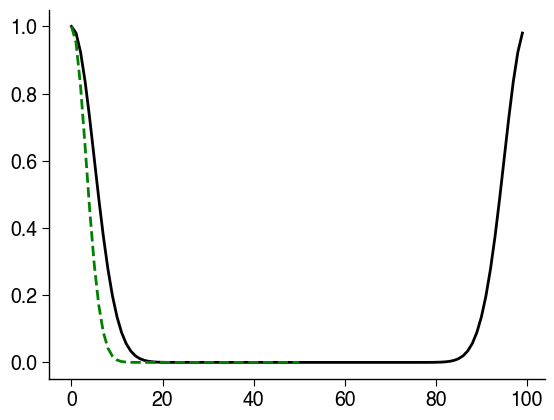

In [23]:
g = tp.gaussian_kernel_1d(100, 5.0, fourier=False)
G = tp.gaussian_kernel_1d(100, 5.0, fourier=True)
plt.plot(g / g.max(), "k-")
plt.plot(G, "g--")

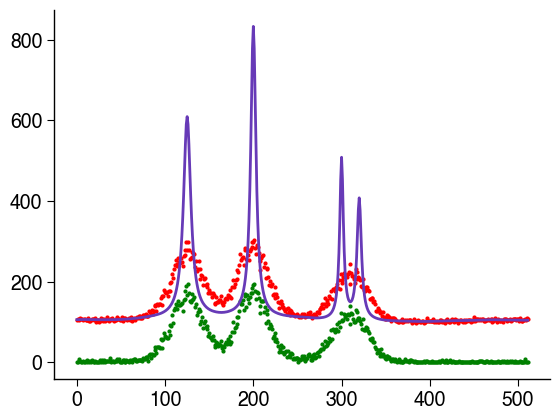

In [46]:
np.random.seed(42)
n = 512
x = np.arange(n)

bg = tp.make_nonuniform_background(n, correlation_length=25.0)

signal = sum(
    [
        tp.lorentzian(x, 125, 5.0, 500.0),
        tp.lorentzian(x, 200, 3.5, 720.0),
        tp.lorentzian(x, 300, 2.5, 400.0),
        tp.lorentzian(x, 320, 3.0, 300.0),
    ]
)

clean_signal = bg + signal
otf = tp.gaussian_kernel_1d(n, 15.0, fourier=True)

blurred = fft.irfft(otf * fft.rfft(signal), n=n)
quantized = np.random.poisson(blurred)
data_no_bg = np.maximum(quantized + np.random.randn(n) * 2.5, 0.0)
data = quantized + bg + np.random.randn(n) * 2.5


plt.plot(clean_signal)
plt.plot(data, 'r.', ms=4, zorder=-1)
plt.plot(data_no_bg, 'g.', ms=4, zorder=-1)

In [41]:
def forward(x, otf):
    ft_x = fft.rfft(x)
    return fft.irfft(ft_x * otf, n=x.size)

def adjoint(v, otf):
    ft_v = fft.rfft(v)
    return fft.irfft(ft_v * np.conj(otf), n=v.size)

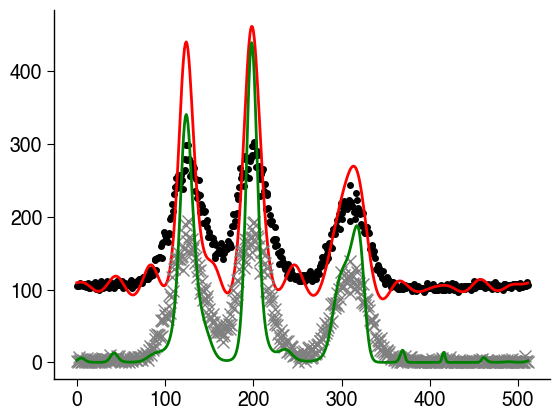

In [50]:
# do standard richardson lucy
fest = np.ones(n)

for k in range(500):
    model = forward(fest, otf)
    ratio = data / model
    fest = fest * adjoint(ratio, otf)

fest_no_bg = np.ones(n)
for k in range(500):
    model = forward(fest_no_bg, otf)
    ratio = data_no_bg / model
    fest_no_bg = fest_no_bg * adjoint(ratio, otf)

plt.plot(data, 'k.')
plt.plot(fest, 'r-')
plt.plot(data_no_bg, 'x', c="0.5")
plt.plot(fest_no_bg, 'g-')